# Trabajo Final Inteligencia Artificial I - año 2018: Visión Artificial
---

# [Dependencias y resultados previos](./02-filtracion.ipynb)

## Dependencias

In [22]:
import numpy as np

from matplotlib import pyplot as plt
plt.rcParams['image.cmap'] = 'gray'

from skimage import io, color, img_as_float, img_as_ubyte, filters

## Resultados

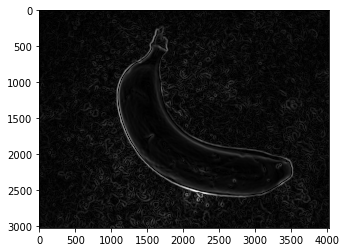

In [42]:
img = io.imread('./imgs/examples/banana_example.jpg')
banana_float = img_as_float(img)

banana = color.rgb2gray(banana_float)
banana_gauss = filters.gaussian(banana, sigma=10)
banana_clean = filters.sobel(banana_gauss)

fig, ax = plt.subplots()
ax.imshow(banana_clean)

---

# Segmentado de imágenes
---

El segmentado de las imágenes consiste en extraer de la imágen la información limpia del objeto a analizar, en este caso una banana. Consiste en separar el objeto de su entorno que no provee información útil. Este proceso nos dejará una imagen más limpia de valores binarios, a la que ya se le podrá extraer las características.

## Histograma

A continuación se realiza un histograma de la imagen filtrada, donde se puede observar la frecuencia con que se repite cierto valor de intensidad en la imagen.

In [47]:
bins = [0, 0.150]
hist, bin_edges = np.histogram(banana_clean, bins=bins)
# hist: [8]
# bin_edges: [ 0.    0.15]

# Or, if bin is an integer, you can set the number of bins:
bins = 4
hist, bin_edges = np.histogram(banana_clean, bins=bins)

fig, ax = plt.subplots(1, 1)

## Thresholding

Esta técnica se utiliza cuando el contraste de la imagen es suficiente para separar un objeto de su entorno. Basicamente consiste en aislar los pixeles por encima o por debajo de un determinado valor, el **threshold**.